In [1]:
import os
import settings
from datetime import datetime
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import KFold, cross_val_score
from sklearn import pipeline
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, BayesianRidge, Ridge
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [40]:
# Load the data CSV files
def read():
    train = pd.read_csv('sp/train.csv')
    test = pd.read_csv('sp/test.csv')
    print("Train set size:", train.shape)
    print("Test set size:", test.shape)
    print('START data processing', datetime.now(), )


    return train, test

In [41]:
train, test = read()

Train set size: (24840, 32)
Test set size: (10646, 32)
START data processing 2024-05-22 01:20:44.718944


In [54]:
train

,Id,Price,Type,Region,Total Area,Bathrooms,Bedrooms,Vacancies,dist_subway,dist_bus,...,varanda,academia,duplex,quintal,armário,reformado,sobrado,condicionado,condominio,escritorio
0,2513199540,3900,house,zona sul,145,3,2,2,266.0,178.0,...,0,0,0,0,0,0,0,0,0,0
1,2509676937,2700,apartament,zona leste,96,4,3,2,936.0,14.0,...,0,0,0,0,0,0,0,0,0,0
2,2509791998,2800,apartament,centro,34,1,1,1,122.0,66.0,...,0,0,0,0,0,0,0,0,0,0
3,2513335521,2100,apartament,zona oeste,65,2,2,2,1545.0,196.0,...,0,0,0,0,0,0,0,0,0,0
4,2513414291,5600,house,zona oeste,235,4,4,3,2021.0,42.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24835,2510688560,885,house,zona leste,50,1,1,1,110.0,81.0,...,0,0,0,0,0,0,0,0,0,0
24836,2513497933,3500,apartament,centro,42,1,1,1,443.0,156.0,...,0,0,0,0,0,0,0,0,0,0
24837,2491816647,2700,house,zona leste,260,2,2,2,537.0,20.0,...,0,0,0,0,0,0,1,0,0,0
24838,2512709620,1950,apartament,centro,52,1,1,0,242.0,78.0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
def preprocess_features(df):
    """
    Preprocess the features of the given DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to preprocess.
    
    Returns:
    pd.DataFrame: The preprocessed DataFrame.
    """
    # Drop the 'Id' column if it exists
    if 'Id' in df.columns:
        df = df.drop('Id', axis=1)
    
    # Separate target variable for training set
    
    y = df['Price']
    df = df.drop('Price', axis=1)

    # Process categorical features
    df = process_categorical_features(df)
    
    return df, y

def process_categorical_features(df):
    """
    Process categorical features by converting them to one-hot encoded variables.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the features.
    
    Returns:
    pd.DataFrame: The DataFrame with processed categorical features.
    """
    categorical_features = ['Type', 'Region']
    df = pd.get_dummies(df, columns=categorical_features, drop_first=True)
    return df

def transform_target(y):
    """
    Transform the target variable using log1p.
    
    Parameters:
    y (pd.Series): The target variable.
    
    Returns:
    pd.Series: The transformed target variable.
    """
    return np.log1p(y)

def features(X):
    """
    Preprocess the training and test datasets.
    
    Parameters:
    train (pd.DataFrame): The training dataset.
    test (pd.DataFrame): The test dataset.
    
    Returns:
    pd.Series, pd.DataFrame, pd.DataFrame: Transformed target variable, preprocessed training dataset, preprocessed test dataset.
    """
    X, y = preprocess_features(X)
    
    y = transform_target(y)
    
    return y, X

In [56]:
# Example usage:
y_train, X_train = features(train)
y_test, X_test = features(test)

In [57]:
X_train

,Total Area,Bathrooms,Bedrooms,Vacancies,dist_subway,dist_bus,dist_school,ncult,food,crime%,...,reformado,sobrado,condicionado,condominio,escritorio,Type_house,Region_zona leste,Region_zona norte,Region_zona oeste,Region_zona sul
0,145,3,2,2,266.0,178.0,349.0,2.0,7.0,0.961461,...,0,0,0,0,0,1,0,0,0,1
1,96,4,3,2,936.0,14.0,323.0,6.0,27.0,0.226226,...,0,0,0,0,0,0,1,0,0,0
2,34,1,1,1,122.0,66.0,505.0,110.0,190.0,3.280278,...,0,0,0,0,0,0,0,0,0,0
3,65,2,2,2,1545.0,196.0,660.0,6.0,6.0,1.187687,...,0,0,0,0,0,0,0,0,1,0
4,235,4,4,3,2021.0,42.0,59.0,0.0,0.0,0.064636,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24835,50,1,1,1,110.0,81.0,253.0,2.0,0.0,0.169670,...,0,0,0,0,0,1,1,0,0,0
24836,42,1,1,1,443.0,156.0,123.0,165.0,97.0,5.873798,...,0,0,0,0,0,0,0,0,0,0
24837,260,2,2,2,537.0,20.0,207.0,1.0,0.0,0.347419,...,0,1,0,0,0,1,1,0,0,0
24838,52,1,1,0,242.0,78.0,354.0,141.0,87.0,5.017371,...,0,0,0,0,0,0,0,0,0,0


In [26]:
def rmse(y_true, y_pred):
    """
    Calculate the root mean squared error between the true and predicted values.
    
    Parameters:
    y_true (pd.Series): The true target values.
    y_pred (pd.Series): The predicted target values.
    
    Returns:
    float: The root mean squared error.
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

def cv_rmse(model, X, y, n_folds=5, random_state=42):
    """
    Calculate the cross-validated root mean squared error for a given model.
    
    Parameters:
    model (object): The regression model to evaluate.
    X (pd.DataFrame): The feature set.
    y (pd.Series): The target variable.
    n_folds (int): The number of folds for K-Fold cross-validation.
    random_state (int): The random state for reproducibility.
    
    Returns:
    np.ndarray: The RMSE scores for each fold.
    """
    kf = KFold(n_splits=n_folds, random_state=random_state, shuffle=True)
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse_scores


In [24]:
def predict(y_train, train, y_test, test, n_folds=5, random_state=42):
    """
    Train models and evaluate their performance on the test set.
    
    Parameters:
    y_train (pd.Series): The training target variable.
    train (pd.DataFrame): The training feature set.
    test (pd.DataFrame): The test feature set.
    test_file_path (str): The file path to the test data with actual prices.
    n_folds (int): The number of folds for K-Fold cross-validation.
    random_state (int): The random state for reproducibility.
    """
    cv_scores = []
    cv_std = []

    print('\nLinear Regression:')
    linear_reg = LinearRegression()
    linear_reg_rmse_scores = cv_rmse(linear_reg, train, y_train, n_folds, random_state)
    
    print(f'Score Model => Mean: {linear_reg_rmse_scores.mean()}, Std: {linear_reg_rmse_scores.std()}')
    
    cv_scores.append(linear_reg_rmse_scores.mean())
    cv_std.append(linear_reg_rmse_scores.std())
    
    linear_reg.fit(train, y_train)
    y_pred = linear_reg.predict(test)
    
    print('RMSE on Test Data:', rmse(y_test, y_pred))

In [61]:
n_folds=5
random_state=42
linear_reg = LinearRegression()
linear_reg_rmse_scores = cv_rmse(linear_reg, X_train, y_train, n_folds, random_state)

In [62]:
print(f'Score Model => Mean: {linear_reg_rmse_scores.mean()}, Std: {linear_reg_rmse_scores.std()}')

Score Model => Mean: 0.3829180470344114, Std: 0.005059785541798978


In [64]:
linear_reg.fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)
print('RMSE on Test Data:', rmse(y_test, y_pred))


RMSE on Test Data: 0.3798212444917631


In [65]:
xgb_reg = XGBRegressor(learning_rate=0.00922801668420645,
                        n_estimators=4492,
                        max_depth=4,
                        min_child_weight=0.019476741626353912,
                        gamma=0.0038933017613795614,
                        subsample=0.3075828286669299,
                        colsample_bytree=0.16053941121623433,
                        scale_pos_weight=3,
                        reg_alpha=6.89051576939588e-05,
                        objective='reg:squarederror',
                        random_state=random_state)

In [66]:
xgb_reg_rmse_scores = cv_rmse(xgb_reg, X_train, y_train, n_folds, random_state)

In [67]:
print(f'Score Model => Mean: {xgb_reg_rmse_scores.mean()}, Std: {xgb_reg_rmse_scores.std()}')

Score Model => Mean: 0.31679524945972115, Std: 0.0034301674756931693


In [69]:
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)
print('RMSE on Test Data:', rmse(y_test, y_pred))

RMSE on Test Data: 0.31543496187984926


In [70]:
from sklearn.model_selection import GridSearchCV, train_test_split

In [75]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll import scope

In [73]:
# Define your custom objective function to include cross-validation
def objective(params):
    # Initialize the XGBRegressor with the given parameters
    model = XGBRegressor(**params)

    # Perform cross-validation
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    rmse_scores = []
    for train_index, val_index in kf.split(X_train):
        X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_val_cv)
        rmse_score = rmse(y_val_cv, y_pred_cv)
        rmse_scores.append(rmse_score)

    # Calculate the mean RMSE across folds
    mean_rmse = np.mean(rmse_scores)

    return {'loss': mean_rmse, 'status': STATUS_OK}

In [77]:
# Define the search space
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 5000, 1)),
    'gamma': hp.loguniform('gamma', -6, -1),
    'subsample': hp.uniform('subsample', 0.1, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:squarederror',
    'seed': 42
}

# Perform hyperparameter tuning
trials = Trials()
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

print("Best parameters found:", best_result)

100%|██████████| 100/100 [44:42<00:00, 26.82s/trial, best loss: 0.30818135508666233]  
Best parameters found: {'colsample_bytree': 0.5414237471859427, 'gamma': 0.15701857394848265, 'learning_rate': 0.04981785270353043, 'max_depth': 8.0, 'min_child_weight': 3.5358214114765483, 'n_estimators': 2892.0, 'reg_alpha': 0.11739494505661574, 'reg_lambda': 0.02587707852884542, 'subsample': 0.7582176452495203}


In [89]:
xgb_reg = XGBRegressor(colsample_bytree= 0.5414237471859427,
                          gamma= 0.15701857394848265,
                          learning_rate= 0.04981785270353043,
                          max_depth= 8,
                          min_child_weight= 3.5358214114765483,
                          n_estimators= 2892,
                          reg_alpha= 0.11739494505661574,
                          reg_lambda= 0.02587707852884542,
                          subsample= 0.7582176452495203)

In [90]:
xgb_reg_rmse_scores = cv_rmse(xgb_reg, X_train, y_train, n_folds, random_state)

In [91]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5414237471859427, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.15701857394848265,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04981785270353043,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=3.5358214114765483, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2892,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [92]:
y_pred = xgb_reg.predict(X_test)

In [93]:
print(f'Score Model => Mean: {xgb_reg_rmse_scores.mean()}, Std: {xgb_reg_rmse_scores.std()}')

Score Model => Mean: 0.308918769690696, Std: 0.0029047486660492006


In [94]:
print('RMSE on Test Data:', rmse(y_test, y_pred))

RMSE on Test Data: 0.306274450412994


Top features:
              Feature  Importance
1           Bathrooms    0.209438
3           Vacancies    0.115483
30  Region_zona norte    0.108889
28         Type_house    0.104153
0          Total Area    0.098129
29  Region_zona leste    0.096410
2            Bedrooms    0.045919
32    Region_zona sul    0.042848
31  Region_zona oeste    0.021701
11          longitude    0.014750
20             duplex    0.012634
14          mobiliado    0.011789
24            sobrado    0.011755
9              crime%    0.011108
10           latitude    0.011013


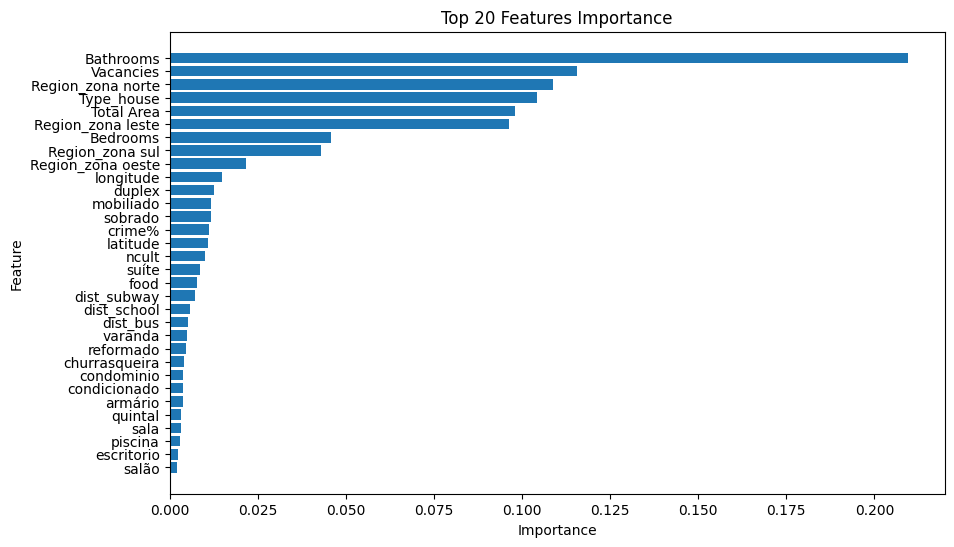

In [102]:
# Assuming best_model is your trained XGBRegressor model
feature_importance = xgb_reg.feature_importances_

# Assuming X_train is your feature matrix
feature_names = X_train.columns

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the top features
print("Top features:")
print(feature_importance_df.head(15))

# You can also visualize the feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:32], feature_importance_df['Importance'][:32])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Features Importance')
plt.gca().invert_yaxis()
plt.show()


In [105]:
# Define the search space for gradient boosting

search_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 5000, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'subsample': hp.uniform('subsample', 0.1, 1),
    'loss': hp.choice('loss', ['squared_error', 'huber', 'quantile', 'absolute_error']),
    'alpha': hp.loguniform('alpha', -5, -1),
    'random_state': 42
}

# Define your custom objective function to include cross-validation

def objective(params):
    # Initialize the GradientBoostingRegressor with the given parameters
    model = GradientBoostingRegressor(**params)

    # Perform cross-validation
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    rmse_scores = []
    for train_index, val_index in kf.split(X_train):
        X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_val_cv)
        rmse_score = rmse(y_val_cv, y_pred_cv)
        rmse_scores.append(rmse_score)

    # Calculate the mean RMSE across folds
    mean_rmse = np.mean(rmse_scores)

    return {'loss': mean_rmse, 'status': STATUS_OK}

# Perform hyperparameter tuning

trials = Trials()
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

print("Best parameters found:", best_result)

100%|██████████| 100/100 [4:04:52<00:00, 146.93s/trial, best loss: 0.3235136271224245]  
Best parameters found: {'alpha': 0.00950162414020934, 'learning_rate': 0.17227693293800223, 'loss': 3, 'max_depth': 13.0, 'min_samples_leaf': 0.11283425240390052, 'min_samples_split': 0.36470231261738584, 'n_estimators': 2827.0, 'subsample': 0.997558925544396}
